In [1]:
import pandas as pd
import numpy as np
#import tensorflow as tf
#from tensorflow.keras import layers
#from itertools import product
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.special
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import PolynomialFeatures
#from scipy import stats #used to compute z score and remove outliers
from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
def compute_y_from_x(X: np.ndarray):
    return np.cos(X * 10)

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)  # Adjust the input and hidden layer sizes as needed
        self.fc2 = nn.Linear(hidden_size, 1)  # Adjust the hidden and output layer sizes as needed

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
num_data = 200
hidden_size_list = np.arange(1,5001,50)
learning_rate = 0.001
num_epochs = 10000  # Adjust the number of epochs as needed
test_frac = 0.2
num_repeats = 50  # Number of repeats for each hidden size

low, high = -1.0, 1.0
#hidden_size_list = [32, 64, 128]  # Add or modify the list of hidden sizes as desired

hidden_size_losses = []
param_num_losses = []

for hidden_size in tqdm(hidden_size_list):
    train_losses = []
    test_losses = []
    for repeat_idx in range(num_repeats):
        # Generate input data
        x = np.linspace(low, high, num_data)  # Replace with your desired range and number of points

        # Generate target data
        y = compute_y_from_x(x)

        # Split the data into train and test sets
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_frac)

        # Convert data to PyTorch tensors
        x_train_tensor = torch.from_numpy(x_train).float().unsqueeze(1)
        y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
        x_test_tensor = torch.from_numpy(x_test).float().unsqueeze(1)
        y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

        # Create data loaders
        train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Instantiate the network
        model = NeuralNetwork(hidden_size)
        pytorch_total_params = sum(p.numel() for p in model.parameters())

        # Define the loss function
        criterion = nn.MSELoss()

        # Define the optimizer
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        num_epochs = 100  # Adjust the number of epochs as needed

        for epoch in range(num_epochs):
            model.train()  # Set the model in training mode
            train_loss = 0.0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

            train_loss /= len(train_loader.dataset)

            # Evaluate the model on the test set
            model.eval()  # Set the model in evaluation mode
            test_loss = 0.0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    test_loss += loss.item() * inputs.size(0)

            test_loss /= len(test_loader.dataset)

            final_train_loss = train_loss
            final_test_loss = test_loss
            train_losses.append(final_train_loss)
            test_losses.append(final_test_loss)

            #if epoch == num_epochs - 1 and repeat_idx == num_repeats - 1:
            #    print(f"Hidden Size: {hidden_size}, Final Train Loss: {final_train_loss:.4f}, Final Test Loss: {final_test_loss:.4f}")

        hidden_size_losses.append({
            'hidden_size': hidden_size,
            'train_losses': train_losses,
            'test_losses': test_losses
        })

        param_num_losses.append({
            'param_num': pytorch_total_params,
            'train_losses': train_losses,
            'test_losses': test_losses
        })


100%|██████████| 100/100 [4:30:51<00:00, 162.52s/it]  


In [12]:
# Save the above variables in case of corruption

# Save hidden_size_losses to a file
with open('hidden_size_losses.pkl', 'wb') as f:
    pickle.dump(hidden_size_losses, f)

# Save param_num_losses to a file
with open('param_num_losses.pkl', 'wb') as f:
    pickle.dump(param_num_losses, f)

In [6]:
# Load hidden_size_losses from the file
with open('hidden_size_losses.pkl', 'rb') as f:
    hidden_size_losses = pickle.load(f)

with open('param_num_losses.pkl', 'rb') as f:
    param_num_losses = pickle.load(f)

In [10]:
# Create a DataFrame from the hidden_size_losses

data = []
for item in hidden_size_losses:
    hidden_size = item['hidden_size']
    train_losses = item['train_losses']
    test_losses = item['test_losses']
    for train_loss, test_loss in zip(train_losses, test_losses):
        data.append({
            'Hidden Size': hidden_size,
            'Loss Type': 'Train',
            'Loss': train_loss
        })
        data.append({
            'Hidden Size': hidden_size,
            'Loss Type': 'Test',
            'Loss': test_loss
        })


df = pd.DataFrame(data)

# Plot the losses using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Hidden Size", y="Loss", hue="Loss Type")
plt.title("MSE Loss on Train and Test Sets for Different Hidden Sizes")
plt.xlabel("Hidden Size")
plt.ylabel("MSE Loss")
plt.show()

MemoryError: Unable to allocate 763. MiB for an array with shape (50000000,) and data type complex128

In [ ]:
# Plot against parameter number instead of hidden size

data = []
for item in param_num_losses:
    pytorch_total_params = item['param_num']
    train_losses = item['train_losses']
    test_losses = item['test_losses']
    for train_loss, test_loss in zip(train_losses, test_losses):
        data.append({
            'Param Num': pytorch_total_params,
            'Loss Type': 'Train',
            'Loss': train_loss
        })
        data.append({
            'Param Num': pytorch_total_params,
            'Loss Type': 'Test',
            'Loss': test_loss
        })

df = pd.DataFrame(data)

# Plot the losses using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Param Num", y="Loss", hue="Loss Type")
plt.title("MSE Loss on Train and Test Sets for Different Parameter Numbers")
plt.xlabel("Parameter Number")
plt.ylabel("MSE Loss")
plt.show()

In [ ]:
# Prepare the data for plotting
data = []
for item in tqdm(hidden_size_losses[:1000]):
    hidden_size = item['hidden_size']
    train_losses = item['train_losses']
    test_losses = item['test_losses']
    for train_loss, test_loss in zip(train_losses, test_losses):
        data.append({
            'Hidden Size': hidden_size,
            'Loss Type': 'Train',
            'Loss': train_loss
        })
        data.append({
            'Hidden Size': hidden_size,
            'Loss Type': 'Test',
            'Loss': test_loss
        })

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Plot the losses using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Hidden Size", y="Loss", hue="Loss Type")
plt.title("MSE Loss on Train and Test Sets for Different Hidden Sizes")
plt.xlabel("Hidden Size")
plt.ylabel("MSE Loss")
plt.show()

100%|██████████| 1000/1000 [00:06<00:00, 155.20it/s]


# Correcting the data collection software

In [5]:
num_data = 200
hidden_size_list = np.arange(1,5001,50)
learning_rate = 0.001
num_epochs = 3000  # Adjust the number of epochs as needed
test_frac = 0.2
num_repeats = 100  # Number of repeats for each hidden size

low, high = -1.0, 1.0
#hidden_size_list = [32, 64, 128]  # Add or modify the list of hidden sizes as desired

hidden_size_losses = []
param_num_losses = []

for hidden_size in tqdm(hidden_size_list):
    train_losses = []
    test_losses = []
    for repeat_idx in range(num_repeats):
        # Generate input data
        x = np.linspace(low, high, num_data)  # Replace with your desired range and number of points
        #print(repeat_idx)
        # Generate target data
        y = compute_y_from_x(x)

        # Split the data into train and test sets
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_frac)

        # Convert data to PyTorch tensors
        x_train_tensor = torch.from_numpy(x_train).float().unsqueeze(1)
        y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
        x_test_tensor = torch.from_numpy(x_test).float().unsqueeze(1)
        y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

        # Create data loaders
        train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Instantiate the network
        model = NeuralNetwork(hidden_size)
        pytorch_total_params = sum(p.numel() for p in model.parameters())

        # Define the loss function
        criterion = nn.MSELoss()

        # Define the optimizer
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        num_epochs = 100  # Adjust the number of epochs as needed

        for epoch in range(num_epochs):
            model.train()  # Set the model in training mode
            train_loss = 0.0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

            train_loss /= len(train_loader.dataset)

            # Evaluate the model on the test set
            model.eval()  # Set the model in evaluation mode
            test_loss = 0.0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    test_loss += loss.item() * inputs.size(0)

            test_loss /= len(test_loader.dataset)

        final_train_loss = train_loss
        final_test_loss = test_loss
        #train_losses.append(final_train_loss)
        #test_losses.append(final_test_loss)

        if repeat_idx == num_repeats - 1:
            print(f"Hidden Size: {hidden_size}, Final Train Loss: {final_train_loss:.4f}, Final Test Loss: {final_test_loss:.4f}")

        hidden_size_losses.append({
            'hidden_size': hidden_size,
            'train_losses': final_train_loss,
            'test_losses': final_test_loss
        })

        param_num_losses.append({
            'param_num': pytorch_total_params,
            'train_losses': final_train_loss,
            'test_losses': final_test_loss
        })


  1%|          | 1/100 [01:33<2:34:42, 93.76s/it]

Hidden Size: 1, Final Train Loss: 0.5402, Final Test Loss: 0.5199


  2%|▏         | 2/100 [03:09<2:35:04, 94.94s/it]

Hidden Size: 51, Final Train Loss: 0.4537, Final Test Loss: 0.4680


  3%|▎         | 3/100 [04:46<2:35:18, 96.07s/it]

Hidden Size: 101, Final Train Loss: 0.4239, Final Test Loss: 0.3634


  4%|▍         | 4/100 [06:30<2:38:27, 99.04s/it]

Hidden Size: 151, Final Train Loss: 0.3726, Final Test Loss: 0.3522


  5%|▌         | 5/100 [08:11<2:37:41, 99.60s/it]

Hidden Size: 201, Final Train Loss: 0.3559, Final Test Loss: 0.3556


  6%|▌         | 6/100 [09:53<2:37:25, 100.48s/it]

Hidden Size: 251, Final Train Loss: 0.3208, Final Test Loss: 0.4229


  7%|▋         | 7/100 [11:37<2:37:28, 101.59s/it]

Hidden Size: 301, Final Train Loss: 0.3176, Final Test Loss: 0.3519


  8%|▊         | 8/100 [13:23<2:38:02, 103.07s/it]

Hidden Size: 351, Final Train Loss: 0.2831, Final Test Loss: 0.2882


  9%|▉         | 9/100 [15:09<2:37:40, 103.96s/it]

Hidden Size: 401, Final Train Loss: 0.3193, Final Test Loss: 0.2701


 10%|█         | 10/100 [16:58<2:38:11, 105.46s/it]

Hidden Size: 451, Final Train Loss: 0.2725, Final Test Loss: 0.3129


 11%|█         | 11/100 [18:48<2:38:46, 107.03s/it]

Hidden Size: 501, Final Train Loss: 0.2593, Final Test Loss: 0.2194


 12%|█▏        | 12/100 [20:41<2:39:33, 108.79s/it]

Hidden Size: 551, Final Train Loss: 0.2460, Final Test Loss: 0.2858


 13%|█▎        | 13/100 [22:36<2:40:24, 110.63s/it]

Hidden Size: 601, Final Train Loss: 0.2237, Final Test Loss: 0.2459


 14%|█▍        | 14/100 [24:30<2:40:06, 111.70s/it]

Hidden Size: 651, Final Train Loss: 0.2310, Final Test Loss: 0.2008


 15%|█▌        | 15/100 [26:26<2:40:13, 113.10s/it]

Hidden Size: 701, Final Train Loss: 0.2196, Final Test Loss: 0.2253


 16%|█▌        | 16/100 [28:24<2:40:08, 114.39s/it]

Hidden Size: 751, Final Train Loss: 0.2164, Final Test Loss: 0.1680


 17%|█▋        | 17/100 [30:22<2:39:44, 115.47s/it]

Hidden Size: 801, Final Train Loss: 0.1905, Final Test Loss: 0.2197


 18%|█▊        | 18/100 [32:22<2:39:37, 116.80s/it]

Hidden Size: 851, Final Train Loss: 0.2053, Final Test Loss: 0.2197


 19%|█▉        | 19/100 [34:24<2:39:46, 118.35s/it]

Hidden Size: 901, Final Train Loss: 0.1751, Final Test Loss: 0.1790


 20%|██        | 20/100 [36:29<2:40:28, 120.36s/it]

Hidden Size: 951, Final Train Loss: 0.1757, Final Test Loss: 0.1967


 21%|██        | 21/100 [38:35<2:40:41, 122.04s/it]

Hidden Size: 1001, Final Train Loss: 0.1641, Final Test Loss: 0.2177


 22%|██▏       | 22/100 [40:39<2:39:40, 122.83s/it]

Hidden Size: 1051, Final Train Loss: 0.1560, Final Test Loss: 0.1377


 23%|██▎       | 23/100 [42:44<2:38:28, 123.48s/it]

Hidden Size: 1101, Final Train Loss: 0.1828, Final Test Loss: 0.2178


 24%|██▍       | 24/100 [44:49<2:37:00, 123.96s/it]

Hidden Size: 1151, Final Train Loss: 0.1684, Final Test Loss: 0.1971


 25%|██▌       | 25/100 [46:58<2:36:31, 125.22s/it]

Hidden Size: 1201, Final Train Loss: 0.1495, Final Test Loss: 0.1676


 26%|██▌       | 26/100 [49:06<2:35:32, 126.12s/it]

Hidden Size: 1251, Final Train Loss: 0.1452, Final Test Loss: 0.1825


 27%|██▋       | 27/100 [51:16<2:35:01, 127.41s/it]

Hidden Size: 1301, Final Train Loss: 0.1444, Final Test Loss: 0.0998


 28%|██▊       | 28/100 [53:26<2:33:41, 128.08s/it]

Hidden Size: 1351, Final Train Loss: 0.1383, Final Test Loss: 0.1561


 29%|██▉       | 29/100 [55:37<2:32:30, 128.88s/it]

Hidden Size: 1401, Final Train Loss: 0.1421, Final Test Loss: 0.1618


 30%|███       | 30/100 [57:49<2:31:30, 129.86s/it]

Hidden Size: 1451, Final Train Loss: 0.1244, Final Test Loss: 0.1029


 31%|███       | 31/100 [1:00:01<2:30:03, 130.49s/it]

Hidden Size: 1501, Final Train Loss: 0.1331, Final Test Loss: 0.1425


 32%|███▏      | 32/100 [1:02:15<2:29:06, 131.56s/it]

Hidden Size: 1551, Final Train Loss: 0.1408, Final Test Loss: 0.1347


 33%|███▎      | 33/100 [1:04:29<2:27:57, 132.50s/it]

Hidden Size: 1601, Final Train Loss: 0.1250, Final Test Loss: 0.1555


 34%|███▍      | 34/100 [1:06:51<2:28:42, 135.19s/it]

Hidden Size: 1651, Final Train Loss: 0.1102, Final Test Loss: 0.0653


 35%|███▌      | 35/100 [1:09:08<2:27:08, 135.82s/it]

Hidden Size: 1701, Final Train Loss: 0.1209, Final Test Loss: 0.1313


 36%|███▌      | 36/100 [1:11:25<2:25:16, 136.20s/it]

Hidden Size: 1751, Final Train Loss: 0.1269, Final Test Loss: 0.1334


 37%|███▋      | 37/100 [1:13:48<2:25:02, 138.14s/it]

Hidden Size: 1801, Final Train Loss: 0.0922, Final Test Loss: 0.0853


 38%|███▊      | 38/100 [1:16:09<2:23:41, 139.06s/it]

Hidden Size: 1851, Final Train Loss: 0.1123, Final Test Loss: 0.1629


 39%|███▉      | 39/100 [1:18:31<2:22:11, 139.86s/it]

Hidden Size: 1901, Final Train Loss: 0.1119, Final Test Loss: 0.1101


 40%|████      | 40/100 [1:20:53<2:20:33, 140.56s/it]

Hidden Size: 1951, Final Train Loss: 0.1042, Final Test Loss: 0.1022


 41%|████      | 41/100 [1:23:20<2:20:03, 142.43s/it]

Hidden Size: 2001, Final Train Loss: 0.0941, Final Test Loss: 0.1075


 42%|████▏     | 42/100 [1:25:44<2:18:16, 143.05s/it]

Hidden Size: 2051, Final Train Loss: 0.0993, Final Test Loss: 0.0873


 43%|████▎     | 43/100 [1:28:10<2:16:45, 143.95s/it]

Hidden Size: 2101, Final Train Loss: 0.1016, Final Test Loss: 0.1081


 44%|████▍     | 44/100 [1:30:37<2:15:12, 144.86s/it]

Hidden Size: 2151, Final Train Loss: 0.0965, Final Test Loss: 0.0965


 45%|████▌     | 45/100 [1:33:04<2:13:18, 145.43s/it]

Hidden Size: 2201, Final Train Loss: 0.1133, Final Test Loss: 0.1236


 46%|████▌     | 46/100 [1:35:34<2:11:58, 146.63s/it]

Hidden Size: 2251, Final Train Loss: 0.0929, Final Test Loss: 0.0880


 47%|████▋     | 47/100 [1:38:05<2:10:41, 147.94s/it]

Hidden Size: 2301, Final Train Loss: 0.1154, Final Test Loss: 0.1487


 48%|████▊     | 48/100 [1:40:34<2:08:29, 148.25s/it]

Hidden Size: 2351, Final Train Loss: 0.0997, Final Test Loss: 0.1136


 49%|████▉     | 49/100 [1:43:05<2:06:46, 149.16s/it]

Hidden Size: 2401, Final Train Loss: 0.0974, Final Test Loss: 0.1102


 50%|█████     | 50/100 [1:45:37<2:04:59, 149.99s/it]

Hidden Size: 2451, Final Train Loss: 0.0876, Final Test Loss: 0.1085


 51%|█████     | 51/100 [1:48:11<2:03:25, 151.14s/it]

Hidden Size: 2501, Final Train Loss: 0.0958, Final Test Loss: 0.1058


 52%|█████▏    | 52/100 [1:50:47<2:02:15, 152.83s/it]

Hidden Size: 2551, Final Train Loss: 0.1022, Final Test Loss: 0.1356


 53%|█████▎    | 53/100 [1:53:24<2:00:36, 153.97s/it]

Hidden Size: 2601, Final Train Loss: 0.0935, Final Test Loss: 0.0980


 54%|█████▍    | 54/100 [1:56:00<1:58:27, 154.50s/it]

Hidden Size: 2651, Final Train Loss: 0.0754, Final Test Loss: 0.0764


 55%|█████▌    | 55/100 [1:58:37<1:56:35, 155.46s/it]

Hidden Size: 2701, Final Train Loss: 0.0734, Final Test Loss: 0.0753


 56%|█████▌    | 56/100 [2:01:15<1:54:27, 156.08s/it]

Hidden Size: 2751, Final Train Loss: 0.0815, Final Test Loss: 0.0985


 57%|█████▋    | 57/100 [2:03:54<1:52:26, 156.90s/it]

Hidden Size: 2801, Final Train Loss: 0.0811, Final Test Loss: 0.1068


 58%|█████▊    | 58/100 [2:06:38<1:51:15, 158.94s/it]

Hidden Size: 2851, Final Train Loss: 0.0717, Final Test Loss: 0.0872


 59%|█████▉    | 59/100 [2:09:19<1:49:07, 159.70s/it]

Hidden Size: 2901, Final Train Loss: 0.0782, Final Test Loss: 0.0662


 60%|██████    | 60/100 [2:12:00<1:46:47, 160.18s/it]

Hidden Size: 2951, Final Train Loss: 0.1001, Final Test Loss: 0.0766


 61%|██████    | 61/100 [2:14:43<1:44:41, 161.07s/it]

Hidden Size: 3001, Final Train Loss: 0.0605, Final Test Loss: 0.0556


 62%|██████▏   | 62/100 [2:17:28<1:42:43, 162.19s/it]

Hidden Size: 3051, Final Train Loss: 0.0751, Final Test Loss: 0.0924


 63%|██████▎   | 63/100 [2:20:13<1:40:31, 163.01s/it]

Hidden Size: 3101, Final Train Loss: 0.0706, Final Test Loss: 0.0813


 64%|██████▍   | 64/100 [2:23:03<1:38:56, 164.91s/it]

Hidden Size: 3151, Final Train Loss: 0.0810, Final Test Loss: 0.0815


 65%|██████▌   | 65/100 [2:25:49<1:36:27, 165.36s/it]

Hidden Size: 3201, Final Train Loss: 0.0608, Final Test Loss: 0.0742


 66%|██████▌   | 66/100 [2:28:38<1:34:18, 166.43s/it]

Hidden Size: 3251, Final Train Loss: 0.0755, Final Test Loss: 0.0706


 67%|██████▋   | 67/100 [2:31:26<1:31:48, 166.94s/it]

Hidden Size: 3301, Final Train Loss: 0.0752, Final Test Loss: 0.0889


 68%|██████▊   | 68/100 [2:34:16<1:29:30, 167.82s/it]

Hidden Size: 3351, Final Train Loss: 0.0764, Final Test Loss: 0.0951


 69%|██████▉   | 69/100 [2:37:08<1:27:23, 169.13s/it]

Hidden Size: 3401, Final Train Loss: 0.0850, Final Test Loss: 0.0834


 70%|███████   | 70/100 [2:40:00<1:24:56, 169.87s/it]

Hidden Size: 3451, Final Train Loss: 0.0645, Final Test Loss: 0.0921


 71%|███████   | 71/100 [2:42:52<1:22:26, 170.58s/it]

Hidden Size: 3501, Final Train Loss: 0.0600, Final Test Loss: 0.0839


 72%|███████▏  | 72/100 [2:45:46<1:20:02, 171.50s/it]

Hidden Size: 3551, Final Train Loss: 0.0579, Final Test Loss: 0.0684


 73%|███████▎  | 73/100 [2:48:42<1:17:47, 172.89s/it]

Hidden Size: 3601, Final Train Loss: 0.0727, Final Test Loss: 0.0808


 74%|███████▍  | 74/100 [2:51:38<1:15:21, 173.89s/it]

Hidden Size: 3651, Final Train Loss: 0.0721, Final Test Loss: 0.0822


 75%|███████▌  | 75/100 [2:54:36<1:12:59, 175.19s/it]

Hidden Size: 3701, Final Train Loss: 0.0580, Final Test Loss: 0.0508


 76%|███████▌  | 76/100 [2:57:35<1:10:30, 176.26s/it]

Hidden Size: 3751, Final Train Loss: 0.0476, Final Test Loss: 0.0449


 77%|███████▋  | 77/100 [3:00:35<1:08:02, 177.50s/it]

Hidden Size: 3801, Final Train Loss: 0.0643, Final Test Loss: 0.0828


 78%|███████▊  | 78/100 [3:03:36<1:05:23, 178.36s/it]

Hidden Size: 3851, Final Train Loss: 0.0778, Final Test Loss: 0.1028


 79%|███████▉  | 79/100 [3:06:40<1:03:03, 180.14s/it]

Hidden Size: 3901, Final Train Loss: 0.0579, Final Test Loss: 0.0631


 80%|████████  | 80/100 [3:09:44<1:00:28, 181.45s/it]

Hidden Size: 3951, Final Train Loss: 0.0544, Final Test Loss: 0.0663


 81%|████████  | 81/100 [3:12:48<57:42, 182.21s/it]  

Hidden Size: 4001, Final Train Loss: 0.0357, Final Test Loss: 0.0262


 82%|████████▏ | 82/100 [3:15:53<54:50, 182.78s/it]

Hidden Size: 4051, Final Train Loss: 0.0737, Final Test Loss: 0.0826


 83%|████████▎ | 83/100 [3:19:01<52:18, 184.60s/it]

Hidden Size: 4101, Final Train Loss: 0.0555, Final Test Loss: 0.0740


 84%|████████▍ | 84/100 [3:22:07<49:18, 184.89s/it]

Hidden Size: 4151, Final Train Loss: 0.0677, Final Test Loss: 0.0470


 85%|████████▌ | 85/100 [3:25:17<46:36, 186.44s/it]

Hidden Size: 4201, Final Train Loss: 0.0533, Final Test Loss: 0.0550


 86%|████████▌ | 86/100 [3:28:25<43:35, 186.83s/it]

Hidden Size: 4251, Final Train Loss: 0.0600, Final Test Loss: 0.0857


 87%|████████▋ | 87/100 [3:31:32<40:29, 186.85s/it]

Hidden Size: 4301, Final Train Loss: 0.0575, Final Test Loss: 0.0650


 88%|████████▊ | 88/100 [3:34:41<37:31, 187.64s/it]

Hidden Size: 4351, Final Train Loss: 0.0736, Final Test Loss: 0.0762


 89%|████████▉ | 89/100 [3:37:53<34:39, 189.00s/it]

Hidden Size: 4401, Final Train Loss: 0.0637, Final Test Loss: 0.0658


 90%|█████████ | 90/100 [3:41:04<31:34, 189.41s/it]

Hidden Size: 4451, Final Train Loss: 0.0514, Final Test Loss: 0.0640


 91%|█████████ | 91/100 [3:44:16<28:33, 190.34s/it]

Hidden Size: 4501, Final Train Loss: 0.0578, Final Test Loss: 0.0891


 92%|█████████▏| 92/100 [3:47:29<25:28, 191.10s/it]

Hidden Size: 4551, Final Train Loss: 0.0623, Final Test Loss: 0.0633


 93%|█████████▎| 93/100 [3:50:43<22:23, 191.96s/it]

Hidden Size: 4601, Final Train Loss: 0.0405, Final Test Loss: 0.0445


 94%|█████████▍| 94/100 [3:54:00<19:20, 193.43s/it]

Hidden Size: 4651, Final Train Loss: 0.0562, Final Test Loss: 0.0602


 95%|█████████▌| 95/100 [3:57:16<16:11, 194.35s/it]

Hidden Size: 4701, Final Train Loss: 0.0463, Final Test Loss: 0.0398


 96%|█████████▌| 96/100 [4:00:33<12:59, 194.97s/it]

Hidden Size: 4751, Final Train Loss: 0.0475, Final Test Loss: 0.0375


 97%|█████████▋| 97/100 [4:03:50<09:46, 195.65s/it]

Hidden Size: 4801, Final Train Loss: 0.0649, Final Test Loss: 0.0608


 98%|█████████▊| 98/100 [4:07:12<06:34, 197.43s/it]

Hidden Size: 4851, Final Train Loss: 0.0499, Final Test Loss: 0.0788


 99%|█████████▉| 99/100 [4:10:33<03:18, 198.73s/it]

Hidden Size: 4901, Final Train Loss: 0.0802, Final Test Loss: 0.0642


100%|██████████| 100/100 [4:13:54<00:00, 152.34s/it]

Hidden Size: 4951, Final Train Loss: 0.0669, Final Test Loss: 0.1107


C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

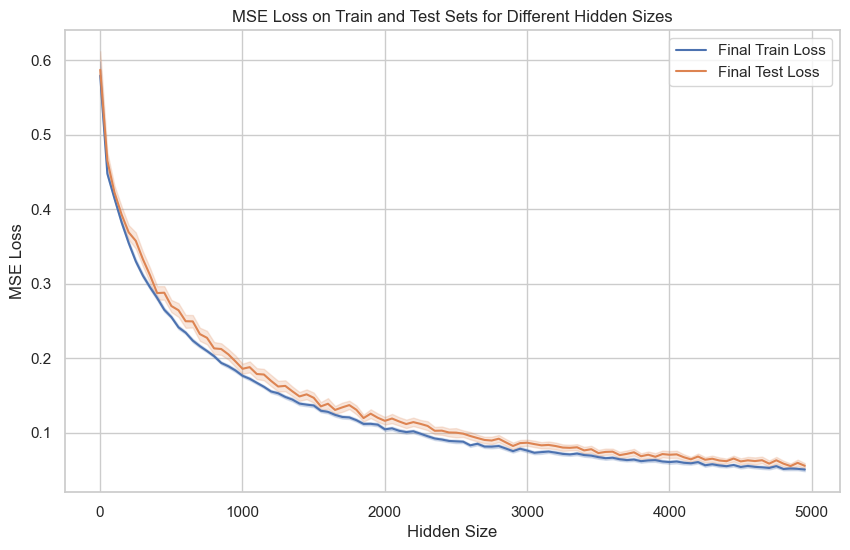

In [6]:
df = pd.DataFrame(hidden_size_losses)

# Plot the losses using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="hidden_size", y="train_losses", label="Final Train Loss")
sns.lineplot(data=df, x="hidden_size", y="test_losses", label="Final Test Loss")
plt.title("MSE Loss on Train and Test Sets for Different Hidden Sizes")
plt.xlabel("Hidden Size")
plt.ylabel("MSE Loss")
plt.show()

# I can also trivially make it dependent on parameter number. However, for this network, the transformation is trivial.